In [1]:
from PIL import Image
import torch
from tqdm.auto import tqdm
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import argparse
from sklearn.neighbors import KernelDensity
from scipy.stats import wasserstein_distance

from point_e.diffusion.configs import DIFFUSION_CONFIGS, diffusion_from_config
from point_e.diffusion.sampler import PointCloudSampler
from point_e.models.download import load_checkpoint
from point_e.models.configs import MODEL_CONFIGS, model_from_config

from point_e.evals.feature_extractor import PointNetClassifier, get_torch_devices
from point_e.evals.fid_is import compute_statistics
from point_e.evals.fid_is import compute_inception_score

In [24]:
def views_to_pointcloud(views, n_views=1):
    """ 
        Add zero color to a point cloud 
        in:     Tensor(n, w, h, 3), int(n)
        out:    Tensor(1, K, (x, y, z, r, g, b))
    """

    base_name = 'base300M' # base40M, use base300M or base1B for better results

    MODEL_CONFIGS[base_name]["n_views"] = n_views
    MODEL_CONFIGS['upsample']["n_views"] = n_views

    print('[-] creating base model...')
    base_model = model_from_config(MODEL_CONFIGS[base_name], device)
    base_model.eval()
    base_diffusion = diffusion_from_config(DIFFUSION_CONFIGS[base_name])

    print('[-] creating upsample model...')
    upsampler_model = model_from_config(MODEL_CONFIGS['upsample'], device)
    upsampler_model.eval()
    upsampler_diffusion = diffusion_from_config(DIFFUSION_CONFIGS['upsample'])

    print("[-] Loading pretrained models...")
    base_model.load_state_dict(load_checkpoint(base_name, device))
    upsampler_model.load_state_dict(load_checkpoint('upsample', device))

    sampler = PointCloudSampler(
        device=device,
        models=[base_model, upsampler_model],
        diffusions=[base_diffusion, upsampler_diffusion],
        num_points=[num_points, 4096-num_points], # points in cloud and missing ones for upsampling
        aux_channels=['R', 'G', 'B'],
        guidance_scale=[3.0, 3.0],
    )

    # Produce a sample from the model.
    samples = None
    for x in tqdm(sampler.sample_batch_progressive(batch_size=1, model_kwargs=dict(images=views))):
        samples = x

    del sampler
    return samples

# ----------------------------------------------
def cloud_distance(cloud1, cloud2, metric=None):
    """ 
        Compute distance between 1d distributions of cloud p2 norms 
        in:     Tensor((x, y, z), K), Tensor((x, y, z), K) 
        out:    Float
    """
    D1 = torch.cdist(cloud1, cloud1, p=2)
    D2 = torch.cdist(cloud2, cloud2, p=2)
    X1 = [float(1/i.sum()) for i in D1]
    X2 = [float(1/i.sum()) for i in D2]
    
    if metric == "gaussian":
        return np.mean(((np.mean(X1) - np.mean(X2))**2).sum()) / (np.std(X1)**2 + np.std(X2)**2)
    else:
        return wasserstein_distance(X1, X2) * 1e5

def plot_distributions(cloud1, cloud2, labels=["cloud1", "cloud2"], idx=0):
    """ 
        Plot 1d distributions of cloud p2 norms 
        in:     Tensor(K, c), Tensor(K, c) 
    """
    D1 = torch.cdist(cloud1, cloud1, p=2)
    D2 = torch.cdist(cloud2, cloud2, p=2)
    
    s = pd.DataFrame({
        labels[0]: [float(1/i.sum()) for i in D1],
        labels[1]: [float(1/i.sum()) for i in D2],
      })
    s.plot.kde(bw_method=0.4, figsize=(24,8), title='poincloud pdf of different objects')
    plt.savefig(f"{idx}_{labels[0]}_{labels[1]}.png")
    
def PIS(clf, cloud):
    """
        Compute P-IS score for a cloud
        in:     PointNetClassifier, Tensor(c, K)
        out:    Float
        https://github.com/halixness/point-e/blob/69e677d8ea47593c33fe2f52fd40e131054c9ce3/point_e/evals/fid_is.py#L73
    """
    cloud = cloud.permute(1,0).unsqueeze(0).cpu().numpy()
    _, preds = clf.features_and_preds(cloud)

    return np.exp(
      np.sum(
        preds[0] * ( np.log(preds[0]) - np.log(np.mean(preds[0])) )
      )
    )

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ToPILImage = transforms.ToPILImage()
num_points = 1024

In [4]:
import os

base_path = os.path.join("..", "..", "Datasets", "shapenet")
views = torch.load(os.path.join(base_path, "images_obj.pt"))
point_clouds = torch.load(os.path.join(base_path, "points.pt"))

In [6]:
ground_objs = []
limit = 10

for i in range(views.shape[0]):
    ground_objs.append([ToPILImage(views[i, j, :, :, :3]) for j in range(4)])

In [7]:
gen_clouds = torch.zeros((len(ground_objs), 2, 6, 4096)) # N, 2, c, K

for i, obj in enumerate(ground_objs):
    
    # Point cloud from single view
    print("====== Single view ======")
    gen_clouds[i, 0, :, :] = views_to_pointcloud(views = [obj[0]], n_views = 1)

    torch.cuda.empty_cache()

    # Point cloud from multi view
    print("\n====== Multi view ======")
    gen_clouds[i, 1, :, :] = views_to_pointcloud(views = obj, n_views = len(obj))
    
    torch.cuda.empty_cache()
    
    if i == limit: break

====== Single view ======
[-] creating base model...
[-] Low Res Diff Transformer set with 1024+256*1 input tokens.
[-] creating upsample model...
[-] High Res Diff Transformer set with 3072+256*1 input tokens.
[-] Loading pretrained models...


0it [00:00, ?it/s]


====== Multi view ======
[-] creating base model...
[-] Low Res Diff Transformer set with 1024+256*4 input tokens.
[-] creating upsample model...
[-] High Res Diff Transformer set with 3072+256*4 input tokens.
[-] Loading pretrained models...


0it [00:00, ?it/s]

====== Single view ======
[-] creating base model...
[-] Low Res Diff Transformer set with 1024+256*1 input tokens.
[-] creating upsample model...
[-] High Res Diff Transformer set with 3072+256*1 input tokens.
[-] Loading pretrained models...


0it [00:00, ?it/s]


====== Multi view ======
[-] creating base model...
[-] Low Res Diff Transformer set with 1024+256*4 input tokens.
[-] creating upsample model...
[-] High Res Diff Transformer set with 3072+256*4 input tokens.
[-] Loading pretrained models...


0it [00:00, ?it/s]

In [33]:
clf = PointNetClassifier(devices=get_torch_devices(), cache_dir=None)


====== [0] Point cloud divergences ======
[+] Ground truth - Single view divergence: 		17.847729131403867
[+] Ground truth - Multi view divergence: 		56.44954328261065
[+] Single view - Multi view divergence: 		74.29727241401451
[+] Ground truth P-IS: 		36.32828140258789
[+] Single view P-IS: 		32.13360595703125
[+] Multi view P-IS: 		17.13158416748047

====== [1] Point cloud divergences ======
[+] Ground truth - Single view divergence: 		3.1279205103373897
[+] Ground truth - Multi view divergence: 		12.67566565843481
[+] Single view - Multi view divergence: 		9.54774514809742
[+] Ground truth P-IS: 		9.401927947998047
[+] Single view P-IS: 		10.772231101989746
[+] Multi view P-IS: 		21.549156188964844


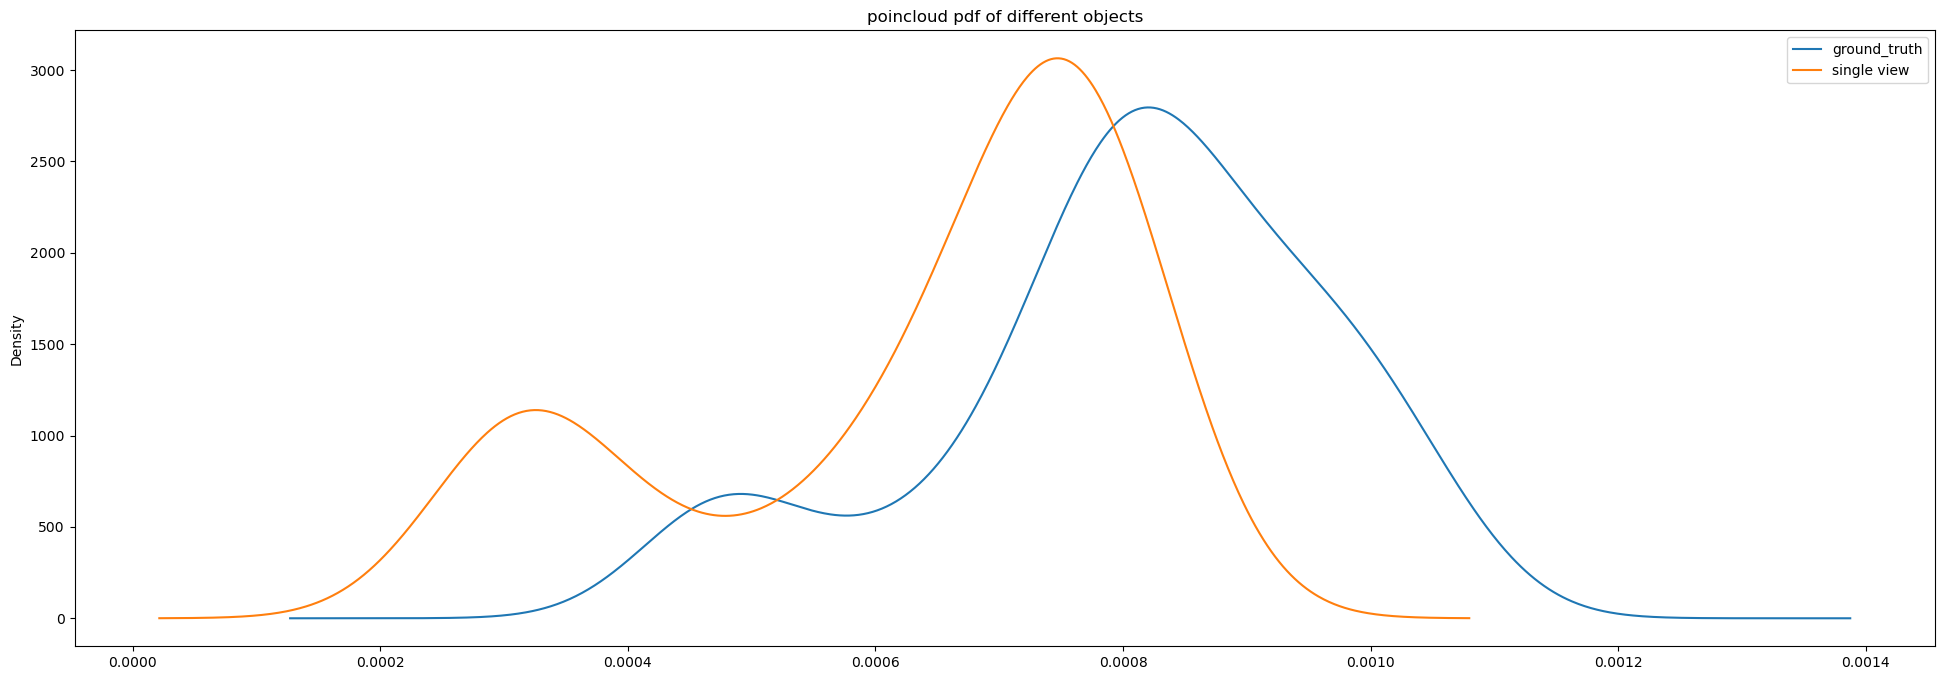

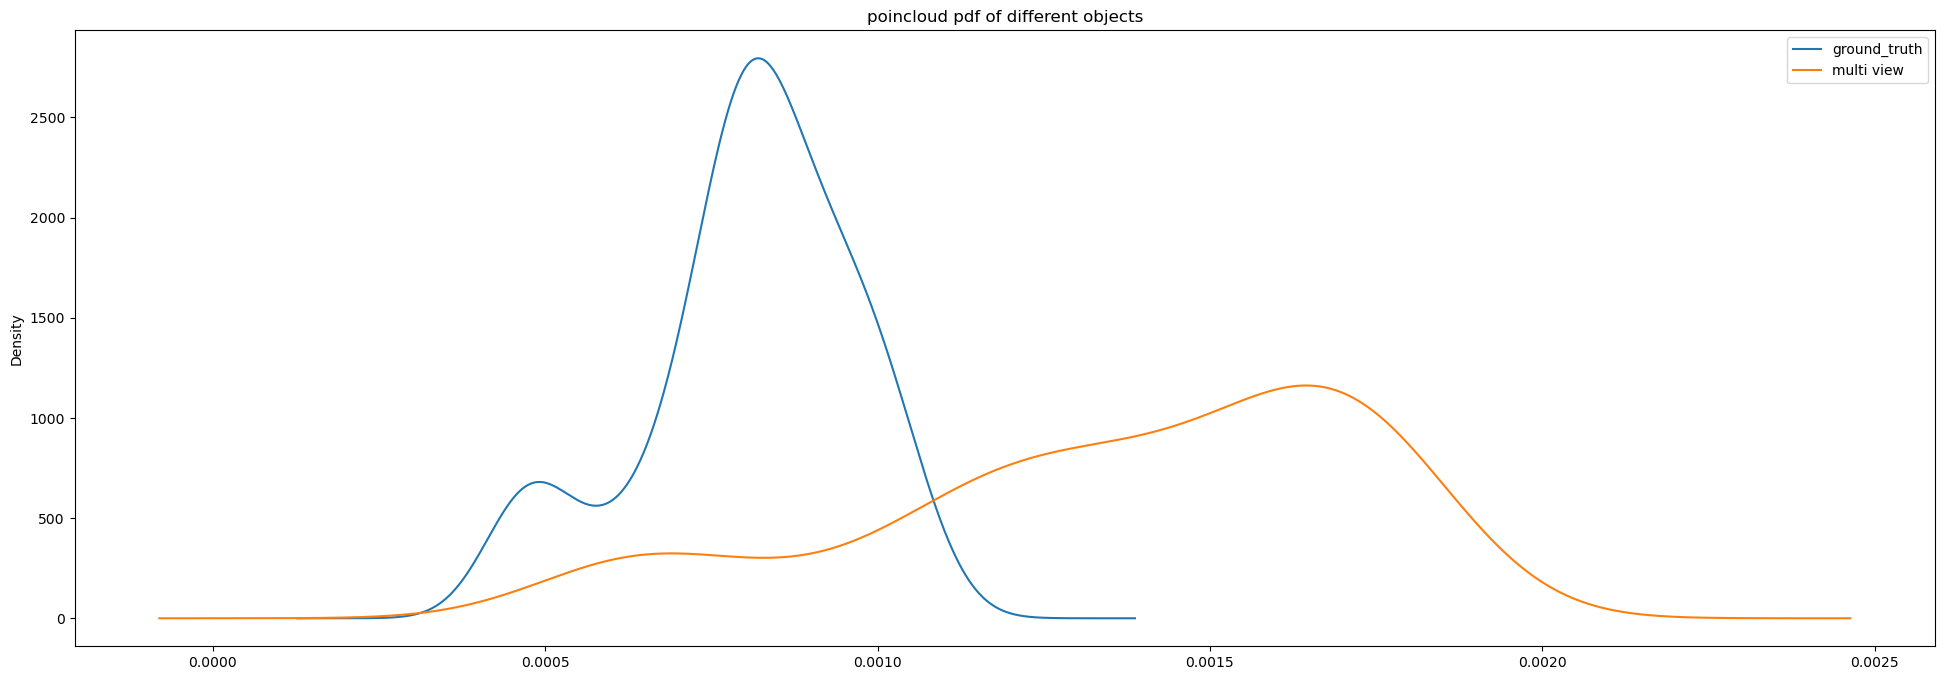

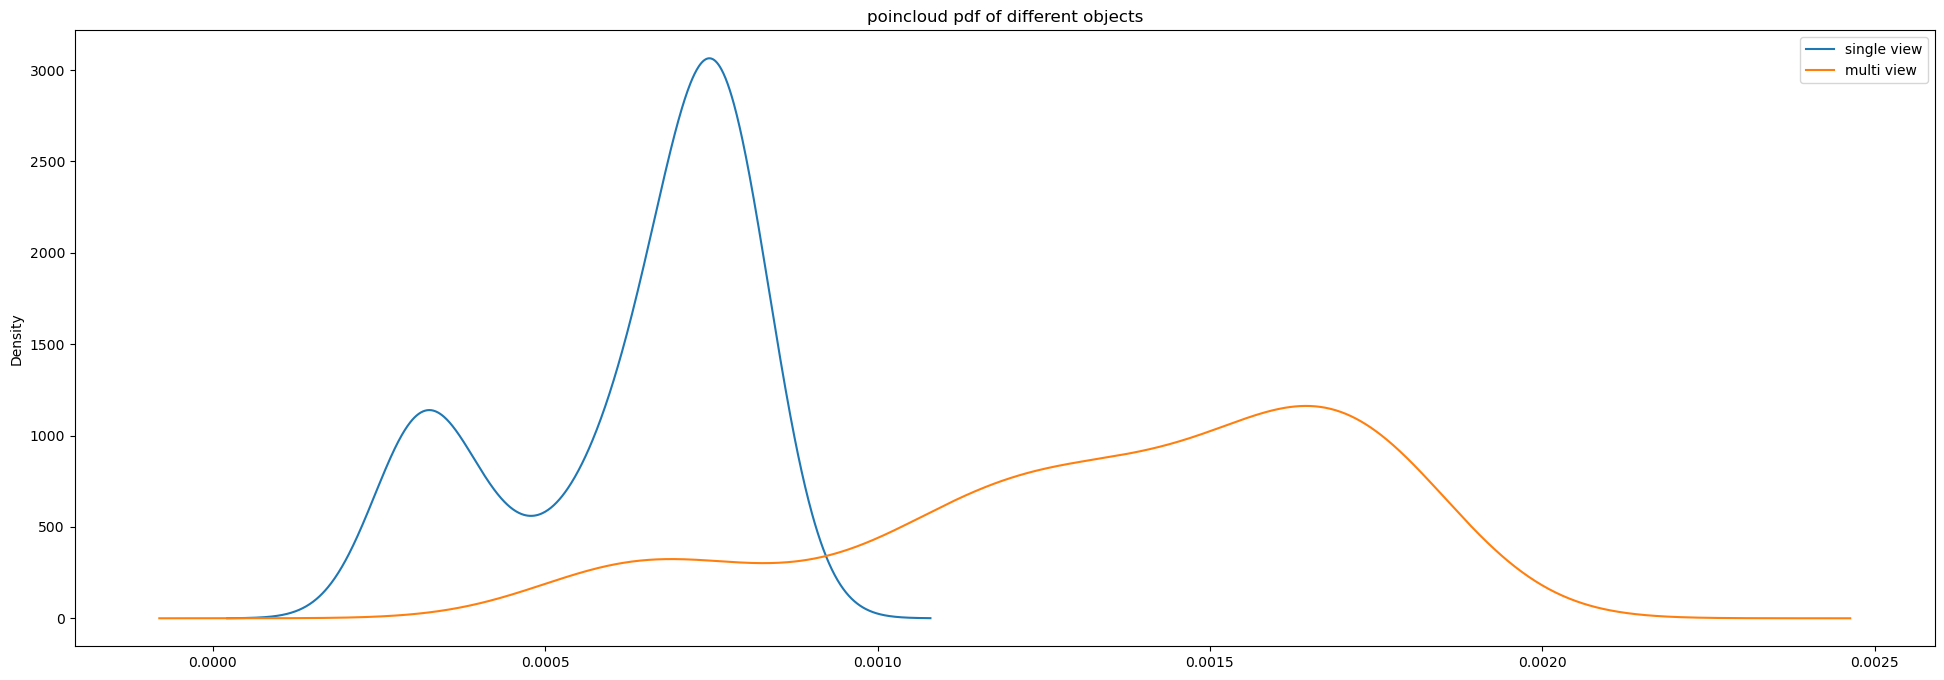

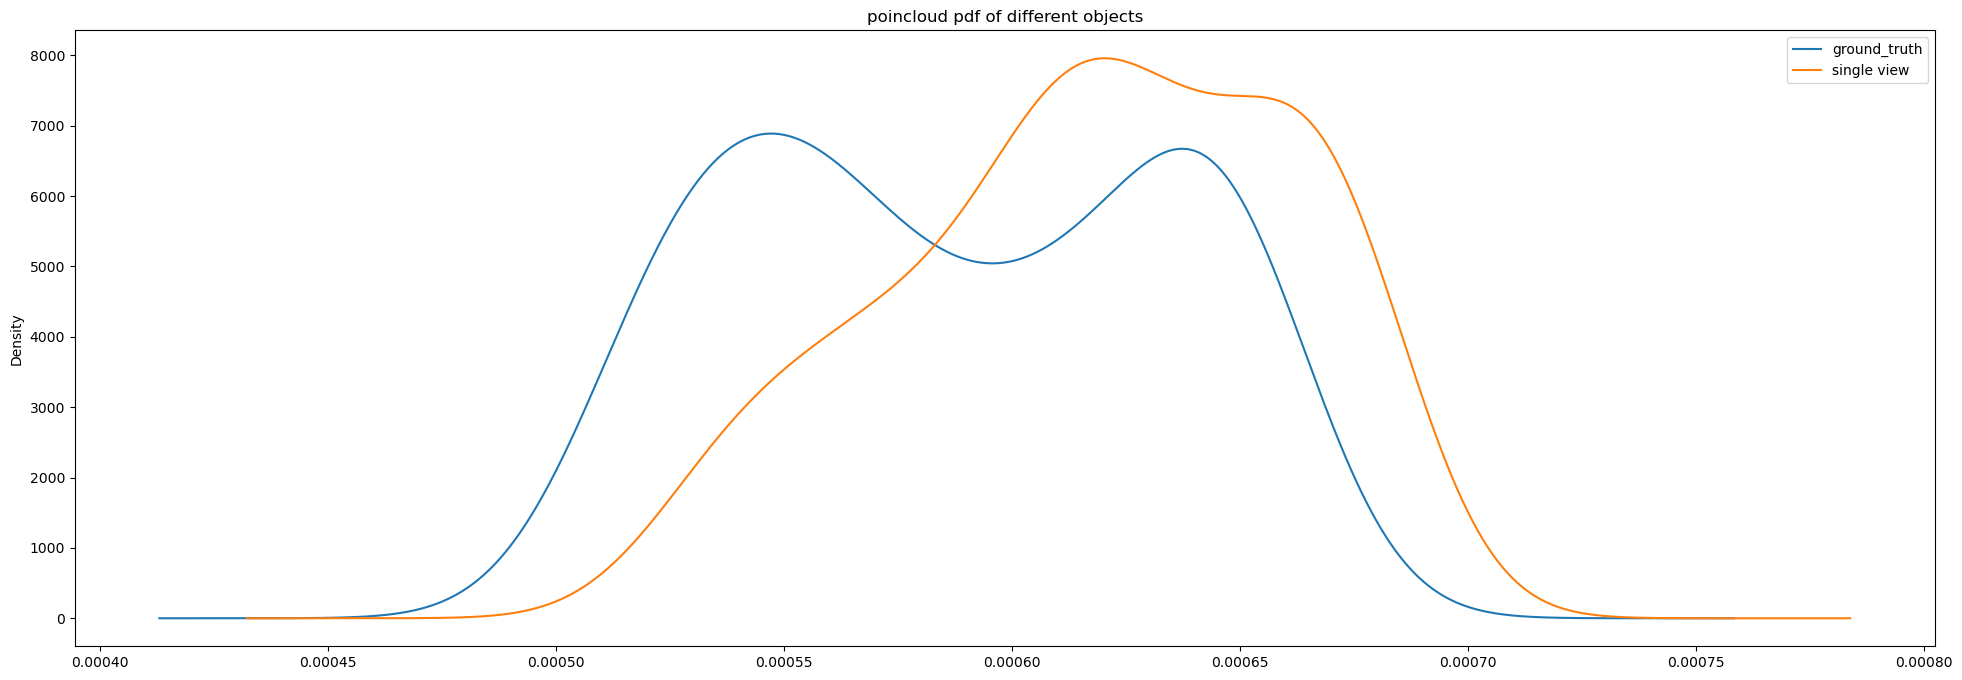

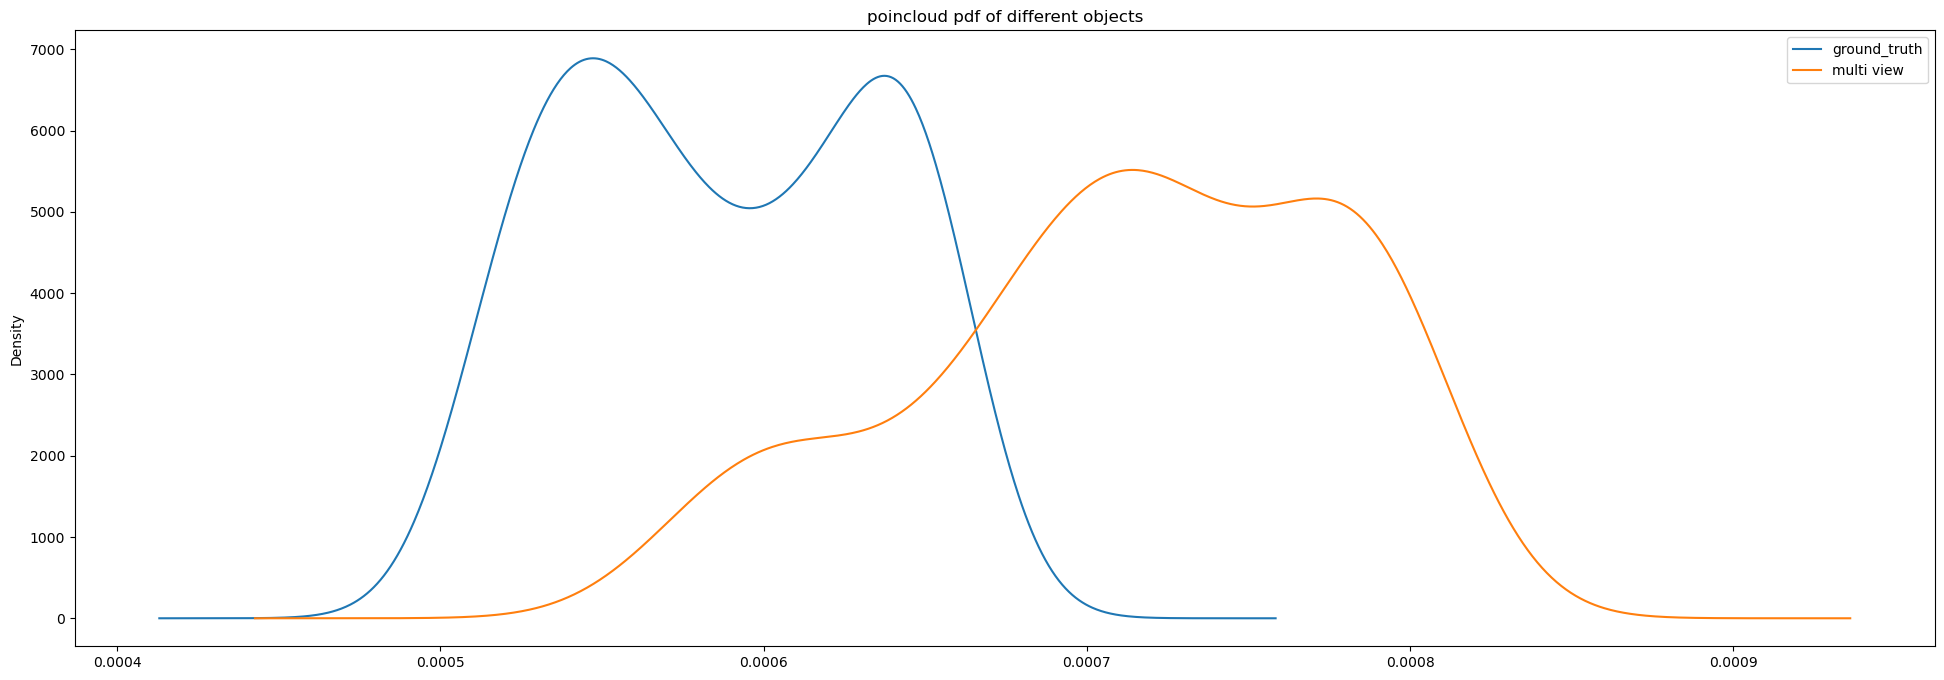

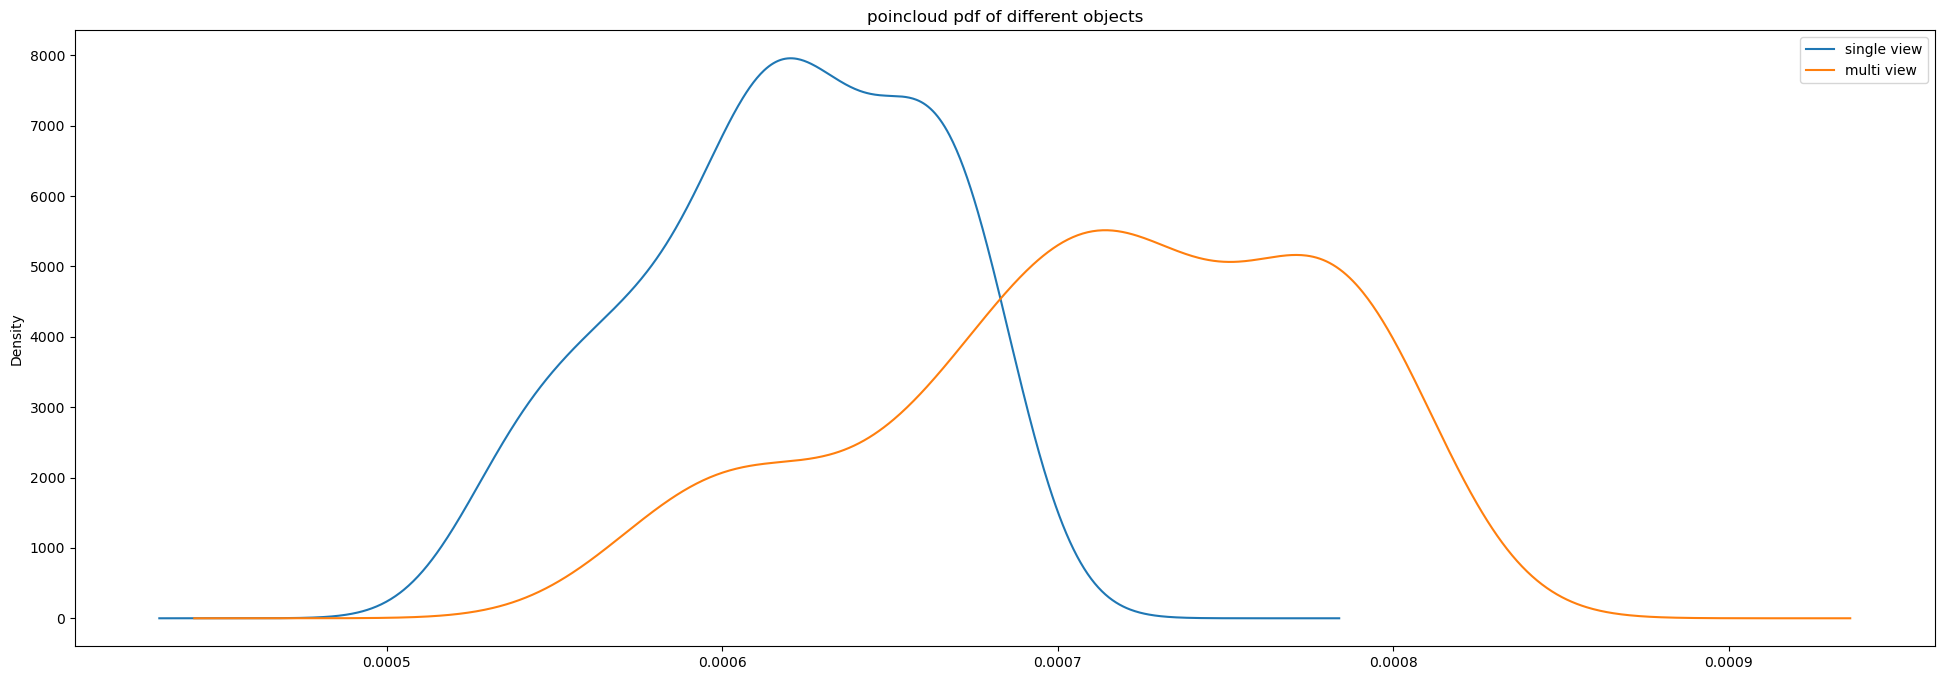

In [38]:
scores = torch.zeros((gen_clouds.shape[0], 3))
for i in range(gen_clouds.shape[0]):
    
    print(f"\n====== [{i}] Point cloud divergences ======")
    
    # ---- Ground - Gen. single
    d_ground_single = cloud_distance(
        torch.Tensor(point_clouds[i]), 
        gen_clouds[i, 0, :3, :].permute(1,0)
    )
    
    print("[+] Ground truth - Single view divergence: \t\t{}".format(d_ground_single))

    plot_distributions(
        torch.Tensor(point_clouds[i]),
        gen_clouds[i, 0, :3, :].permute(1,0),
        ["ground_truth", "single view"], 
        i
    )

    # ---- Ground - Gen. multi
    d_ground_multi = cloud_distance(
        torch.Tensor(point_clouds[i]), 
        gen_clouds[i, 1, :3, :].permute(1,0)
    )
    print("[+] Ground truth - Multi view divergence: \t\t{}".format(d_ground_multi))

    plot_distributions(
        torch.Tensor(point_clouds[i]),
        gen_clouds[i, 1, :3, :].permute(1,0),
        ["ground_truth", "multi view"], 
        i
    )

    # ---- Gen. single - Gen. multi
    d_single_multi = cloud_distance(
        gen_clouds[i, 0, :3, :].permute(1,0), 
        gen_clouds[i, 1, :3, :].permute(1,0)
    )
    print("[+] Single view - Multi view divergence: \t\t{}".format(d_single_multi))

    plot_distributions(
        gen_clouds[i, 0, :3, :].permute(1,0), 
        gen_clouds[i, 1, :3, :].permute(1,0), 
        ["single view", "multi view"], 
        i
    )
    
    print(f"[+] Ground truth P-IS: \t\t{PIS(clf, torch.Tensor(point_clouds[i]).permute(1,0))}")
    print(f"[+] Single view P-IS: \t\t{PIS(clf, gen_clouds[i, 0, :3, :])}")
    print(f"[+] Multi view P-IS: \t\t{PIS(clf, gen_clouds[i, 1, :3, :])}")
    
    scores[i, :] = torch.Tensor([d_ground_single, d_ground_multi, d_single_multi])
    
    if i == limit: break